In [ ]:
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'cse256_project'
assert FOLDERNAME is not None, "[!] Enter the foldername."
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd /content/drive/My\ Drive/$FOLDERNAME/

Mounted at /content/drive
/content/drive/My Drive/project


Importing necessary libraries and modules.

In [2]:
import pandas as pd
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AdamW
import torch
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
from nltk.tokenize import word_tokenize
from nltk import download
download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

Setting parameter values

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 128 # read batched of 128 entries for training and evaluation.
block_size = 32 # read chunks of 32 tokens at a time.
learning_rate = 1e-3 # learning rate for AdamW optimiser.
n_embd = 64 # embedding layer dimension.
n_head = 2 # number of attention heads
n_layer = 4 # number of atten head layers.

eval_interval = 100 # evaluate perpelxity for every 100 iterations.
max_iters = 2000 # stop training after 2000 iterations.
eval_iters = 200 # evaluate for 200 iterations.
n_input = 64 # input dimension

Reading from the Hinglish-TOP-Dataset

In [4]:
df_top_train = pd.read_csv("data/train.tsv", sep='\t')
df_top_test = pd.read_csv("data/test.tsv", sep='\t')
df_top_validation = pd.read_csv("data/validation.tsv", sep='\t')

In [5]:
df_github = pd.concat([df_top_train, df_top_test, df_top_validation], axis = 0)
df_github = df_github['cs_query']
df_github

,cs_query
0,9 : 30 am ko Sunday Brunch ke liye ek naya wee...
1,danny ko message karo aur dekho ke he wants to...
2,do ghante ke liye alarm set kardo
3,neil ke liye cake bake karne ke reminder ko mi...
4,Please mere chat requests ko retrieve kare
...,...
1385,Is summer ko outdoor concerts
1386,Mai chahta hu ki aap mere alarm ko 10 minutes ...
1387,please Tupac play kare
1388,Rhonda ko message kare aur July me Vacation Bi...


Reading from the the english-to-hinglish dataset from Hugging face

In [6]:
df_hugging = pd.read_json("hf://datasets/findnitai/english-to-hinglish/hinglish_upload_v1.json", lines=True)
df_hugging = df_hugging['translation'].apply(lambda x: x.get('hi_ng'))
df_hugging.name = 'cs_query'
df = pd.concat([df_github, df_hugging]).drop_duplicates().reset_index(drop=True)
df = df.str.replace('\n', '', regex=False).str.replace('\t', '', regex=False)
df

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


,cs_query
0,9 : 30 am ko Sunday Brunch ke liye ek naya wee...
1,danny ko message karo aur dekho ke he wants to...
2,do ghante ke liye alarm set kardo
3,neil ke liye cake bake karne ke reminder ko mi...
4,Please mere chat requests ko retrieve kare
...,...
162026,udbilaao . . wow bahut din baad yeh suna hai...
162027,"Dr Kumar Vishwas: ""Koi deewana kehta hai.. koi..."
162028,Me: Aaj kuch toofani karte hai.Mom: Pani ki bo...
162029,"Pyar mangi to Jaan dengi,milk mango to kher de..."


Splitting into training and testing dataset. 70% training, 30% testing.

In [7]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)
print(df_train.head())
print(df_test.head())

45894                weekend par kitni barish expected hai
75239     next two days ke liye sabhi alarms ko band kardo
42566                     San Diego me kitne miles door he
58370                Mere liye thoda christian music bajao
76526    mere church ke liye is hafte koi bhi reminders...
Name: cs_query, dtype: object
12479     Batana to difficult he , probably dono ke liye he
476                       Florida mei kitna temperature hai
97038     train se Eagles parade tak pahunchne ke liye s...
123789    Harry ko message karo ki happy birthday to you...
92097                       is song ko rok do aur skip kare
Name: cs_query, dtype: object


Concatenate all the training and testing texts into one large text.

In [8]:
train_text = ' '.join(df_train.astype(str))
test_text  = ' '.join(df_test.astype(str))

Dataset class to hold training and testing set entries. Inspired from the starter code in PA2.

In [9]:
class LanguageModelingDataset(torch.utils.data.Dataset):
    def __init__(self, tokenizer, text, block_size):
        self.tokenizer = tokenizer
        self.data = torch.tensor(self.tokenizer.encode(text), dtype=torch.long)
        self.block_size = block_size

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        chunk = self.data[idx:idx + self.block_size + 1]
        x = chunk[:-1]
        y = chunk[1:]
        return x, y

Simple whole word tokeniser. Inspired from the starter code in PA2.

In [10]:
class SimpleTokenizer:
    def __init__(self, text):
        self.vocab = set()
        self.stoi = {}
        self.itos = {}
        self.build_vocab(text)

    def build_vocab(self, text):
        tokens = word_tokenize(text)
        self.vocab = set(tokens)
        self.vocab_size = len(self.vocab) + 2
        self.stoi = {word: i for i, word in enumerate(self.vocab, start=2)}
        self.stoi['<pad>'] = 0
        self.stoi['<unk>'] = 1
        self.itos = {i: word for word, i in self.stoi.items()}

    def encode(self, text):
        tokens = word_tokenize(text)
        return [self.stoi.get(word, self.stoi['<unk>']) for word in tokens]

    def decode(self, indices):
        return ' '.join([self.itos.get(index, '<unk>') for index in indices])

Helper functions. `collate_batch` and `compute_perplexity` functions inspired frmo the starter code in PA2.

In [11]:
def collate_batch(batch):
    data, labels = zip(*batch)

    padded_sequences = pad_sequence(data, batch_first=True, padding_value=0)
    padded_sequences = padded_sequences[:, :block_size]

    padded_sequences = torch.nn.functional.pad(padded_sequences, (0, max(0, block_size - padded_sequences.shape[1])), "constant", 0)
    labels = torch.stack(labels)
    return padded_sequences, labels

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def compute_perplexity(decoderLMmodel, data_loader, eval_iters=100):
    decoderLMmodel.eval()
    losses= []
    for X, Y in data_loader:
        X, Y = X.to(device), Y.to(device)
        output, attention_maps = decoderLMmodel(X, Y)
        logits, loss = output
        losses.append(loss.item())
        if len(losses) >= eval_iters: break

    losses = torch.tensor(losses)
    mean_loss = losses.mean()
    perplexity = torch.exp(mean_loss).item()

    decoderLMmodel.train()
    return perplexity

Implementation of the decoder language model with masked attention heads.

In [12]:
class DecoderModel(nn.Module):
    def __init__(self, vocab_size, d_model, sequence_length, num_heads, num_layers, device):
        super().__init__()
        self.device = device
        self.d_model = d_model
        self.block_size = sequence_length
        self.token_embedding_table = nn.Embedding(vocab_size, d_model)
        self.position_embedding_table = nn.Embedding(sequence_length, d_model)
        self.blocks = nn.ModuleList([Block(d_model, num_heads=num_heads, block_size=sequence_length, mode=1) for _ in range(num_layers)]) # masked attention heads
        self.ln_f = nn.LayerNorm(d_model)
        self.lm_head = nn.Linear(d_model, vocab_size)

    def forward(self, idx, targets = None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=self.device)) # (T,C)
        x = tok_emb + pos_emb

        attention_maps = []
        for block in self.blocks:
            x, attention = block(x)
            attention_maps.append(attention)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = nn.functional.cross_entropy(logits, targets)

        return (logits, loss), attention_maps

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -self.block_size:]
            (logits, loss), _ = self(idx_cond)
            logits = logits[:, -1, :]
            probs = nn.functional.softmax(logits, dim = -1)
            idx_next = torch.multinomial(probs, num_samples = 1)
            idx = torch.cat((idx, idx_next), dim = 1)
        return idx

class MaskedHead(nn.Module):
    def __init__(self, head_size, d_model, block_size):
        super().__init__()
        self.key = nn.Linear(d_model, head_size, bias=False)
        self.query = nn.Linear(d_model, head_size, bias=False)
        self.value = nn.Linear(d_model, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        B, T, C = x.shape
        k, q, v = self.key(x), self.query(x), self.value(x)

        weights = q @ k.transpose(-2, -1) * C**-0.5
        weights = weights.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        weights = nn.functional.softmax(weights, dim=-1)

        outputs = weights @ v
        return outputs, weights

class Head(nn.Module):
    def __init__(self, head_size, d_model):
        super().__init__()
        self.key = nn.Linear(d_model, head_size, bias=False)
        self.query = nn.Linear(d_model, head_size, bias=False)
        self.value = nn.Linear(d_model, head_size, bias=False)

    def forward(self, x):
        B, T, C = x.shape
        k, q, v = self.key(x), self.query(x), self.value(x)

        weights = q @ k.transpose(-2, 1) * C**-0.5
        weights = nn.functional.softmax(weights, dim = -1)

        outputs = weights @ v
        return outputs, weights

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size, d_model, block_size, device, mode = 0):
        super().__init__()
        if mode == 0: # regular
            self.heads = nn.ModuleList([Head(head_size, d_model) for _ in range(num_heads)])
        elif mode == 1: # masked head
            self.heads = nn.ModuleList([MaskedHead(head_size, d_model, block_size) for _ in range(num_heads)])
        self.proj = nn.Linear(num_heads * head_size, d_model)

    def forward(self, x):
        attention_maps = []
        outputs = []
        for head in self.heads:
            head_output, attention = head(x)
            outputs.append(head_output)
            attention_maps.append(attention)

        concat_outputs = torch.cat(outputs, dim = -1)
        output = self.proj(concat_outputs)
        return output, attention_maps[0]

class FeedForward(nn.Module):
    def __init__(self, d_model, hidden_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, d_model)
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, d_model, num_heads, block_size=None, sequence_length=None, device=None, mode=0):
        super().__init__()
        head_size = d_model // num_heads # this may seem redundant but it is not. do not remove.
        self.sa = MultiHeadAttention(num_heads, head_size, d_model, block_size, device, mode)
        self.ffwd = FeedForward(d_model, 100)
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)

    def forward(self, x):
        x_ln1 = self.ln1(x)
        sa_out, attention_map = self.sa(x_ln1)
        x = x + sa_out
        x = x + self.ffwd(self.ln2(x))
        return x, attention_map

Setting up the tokenisers and data loaders. The models with different tokenisers were ran by uncommenting the desired tokeniser and commenting out the others and then initialising the language model with the desired tokeniser.

In [13]:
# tokenizer = SimpleTokenizer(' '.join(df.astype(str)))
# tokenizer = AutoTokenizer.from_pretrained("google/muril-base-cased")
tokenizer = AutoTokenizer.from_pretrained("obaidtambo/hinglish_bert_tokenizer")

train_dataset = LanguageModelingDataset(tokenizer, train_text, block_size)
test_dataset = LanguageModelingDataset(tokenizer, test_text, block_size)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/207k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/686k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1675750 > 512). Running this sequence through the model will result in indexing errors


In [14]:
decoder = DecoderModel(tokenizer.vocab_size, n_embd, n_input, n_head, n_layer, device)
decoder = decoder.to(device)
optimizer = torch.optim.AdamW(decoder.parameters(), lr=learning_rate)

train_perplexities = []
test_perplexities = []
iterations = []

print("Number of parameters in decoder:", count_parameters(decoder))
for i, (xb, yb) in enumerate(train_loader):
    if i >= max_iters:
        break
    xb, yb = xb.to(device), yb.to(device)
    if i % eval_interval == 0 or i == max_iters - 1:
        train_perplexity = compute_perplexity(decoder, train_loader, eval_iters=eval_iters)
        test_perplexity = compute_perplexity(decoder, test_loader, eval_iters=eval_iters)
        train_perplexities.append(train_perplexity)
        test_perplexities.append(test_perplexity)
        iterations.append(i)

        print(f"Iteration {i}.")
        print(f"Training perplexity: {train_perplexity}")
        print(f"Testing perplexity: {test_perplexity}")
        print('')

    output, attention_maps = decoder(xb, yb)
    logits, loss = output
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print(f"Perplexity at {max_iters}th iteration.")
print("Training perplexity:", compute_perplexity(decoder, test_loader, eval_iters=eval_iters))
print(f"Testing perplexity: {compute_perplexity(decoder, test_loader, eval_iters=eval_iters)}")

Number of parameters in decoder: 4060234
Iteration 0.
Training perplexity: 35710.46875
Testing perplexity: 35674.89453125

Iteration 100.
Training perplexity: 318.03131103515625
Testing perplexity: 316.9477844238281

Iteration 200.
Training perplexity: 129.21630859375
Testing perplexity: 128.1681365966797

Iteration 300.
Training perplexity: 73.84593200683594
Testing perplexity: 74.95266723632812

Iteration 400.
Training perplexity: 55.490665435791016
Testing perplexity: 56.83162307739258

Iteration 500.
Training perplexity: 46.48627471923828
Testing perplexity: 46.83998107910156

Iteration 600.
Training perplexity: 40.24882125854492
Testing perplexity: 41.05354309082031

Iteration 700.
Training perplexity: 36.16015625
Testing perplexity: 37.36448287963867

Iteration 800.
Training perplexity: 33.19593811035156
Testing perplexity: 34.47003173828125

Iteration 900.
Training perplexity: 30.575096130371094
Testing perplexity: 32.28254318237305

Iteration 1000.
Training perplexity: 28.95437

Storing the MuRIL training and testing perplexities after running the model with the MuRIL tokeniser.

In [68]:
muril_train_perplexities = train_perplexities
muril_test_perplexities = test_perplexities

Storing the Hinglish training and testing perplexities after running the model with the Hinglish tokeniser from Hugging face.

In [71]:
hinglish_train_perplexities = train_perplexities
hinglish_test_perplexities = test_perplexities

Storing the simple whole word training and testing perplexities after running the model with the simple whole word tokeniser.

In [78]:
simple_train_perplexities = train_perplexities
simple_test_perplexities = test_perplexities

In [83]:
print(muril_train_perplexities)
print(muril_test_perplexities)
print(hinglish_train_perplexities)
print(hinglish_test_perplexities)
print(simple_train_perplexities)
print(simple_test_perplexities)

[235833.890625, 815.7666015625, 471.81103515625, 231.7191619873047, 159.06350708007812, 125.38188171386719, 106.53486633300781, 93.90400695800781, 82.98641204833984, 76.2585678100586, 70.67867279052734, 65.33283996582031, 61.74308776855469, 58.148921966552734, 56.56049346923828, 53.30833053588867, 51.56260681152344, 50.08074951171875, 48.44624328613281, 47.14374923706055, 44.73337936401367]
[235794.3125, 818.77001953125, 482.1761169433594, 236.22238159179688, 164.6836395263672, 132.7476043701172, 114.0820541381836, 101.91905212402344, 90.90861511230469, 84.71671295166016, 81.75749969482422, 76.5454330444336, 70.64771270751953, 69.36902618408203, 65.77267456054688, 64.85125732421875, 62.68998718261719, 61.094478607177734, 59.61241912841797, 59.06044006347656, 58.56596374511719]
[34345.9921875, 318.47137451171875, 123.97037506103516, 72.76806640625, 54.7878532409668, 44.9097900390625, 39.744606018066406, 35.486000061035156, 33.03010177612305, 30.391996383666992, 28.98244857788086, 27.614

Generating Hinglish tokens with empty context.

In [15]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(tokenizer.decode(decoder.generate(context, max_new_tokens=100)[0].tolist()))

[PAD]i expectpanth se pahuchne mei kitni der lagegi [UNK] kya hurricane ka kam koi tarah block wali hai [UNK] to [UNK] aur aage kaam madation hai [UNK] politicaar playrykkrin virodhing sankalwa gayakos hairowkaring log gu gayeused [UNK]ing cover tak kam kon par nahi singth ka istemaal karke [UNK] movieotan ke liye [UNK] salman dwar [UNK] [UNK] ke liye [UNK] n firstit me jane par don


Generating Hinglish tokens with non-empty context. "ghar jaane ke baad" translates to "after returning home".

In [16]:
custom_context = "ghar jaane ke baad"
context_tokens = tokenizer(custom_context, return_tensors="pt").input_ids.to(device)
print(context_tokens)
print(tokenizer.decode(decoder.generate(context_tokens, max_new_tokens=100)[0].tolist()))

tensor([[   2, 1003, 3208,   39, 2411, 4927,    3]], device='cuda:0')
[CLS] ghar jaane ke baad [SEP] karo [UNK] pm ko school ke liye mere paas kitne reminders hai [UNK] mujhe mere plan ke milne ke liye ekoo aaj friedning kiadaainberachus in st clocke par time hai towno karaye mujhe ke liyety recomlist me raat ke liyeellers kabfic inca kiya baslale ke baad don kabo the karenge miney traffic ke liye destination onie ke liye futuro len kar


Plotting data for the models with different tokenisers.

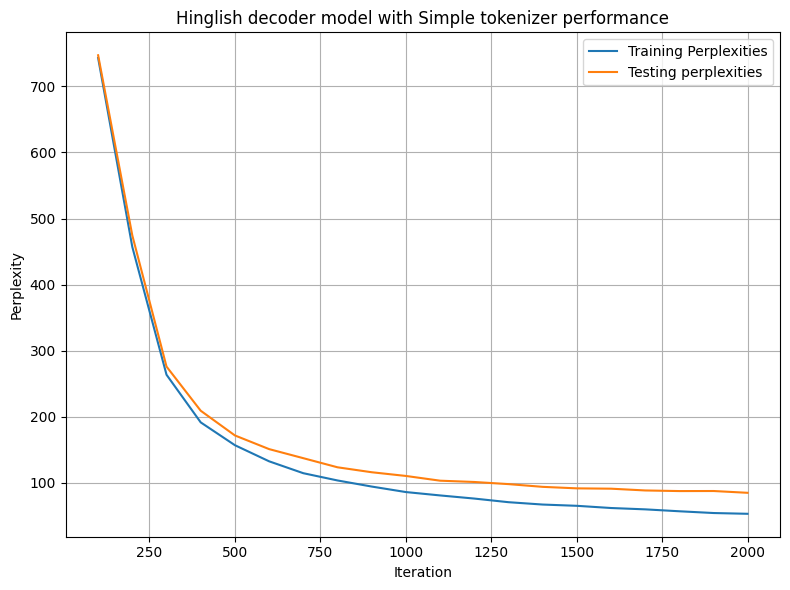

In [89]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(iterations[1:], simple_train_perplexities[1:], label = "Training Perplexities")
plt.plot(iterations[1:], simple_test_perplexities[1:], label = "Testing perplexities")
plt.xlabel("Iteration")
plt.ylabel("Perplexity")
plt.title("Hinglish decoder model with Simple tokenizer performance")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("simple_tokenizer.png")
plt.show()

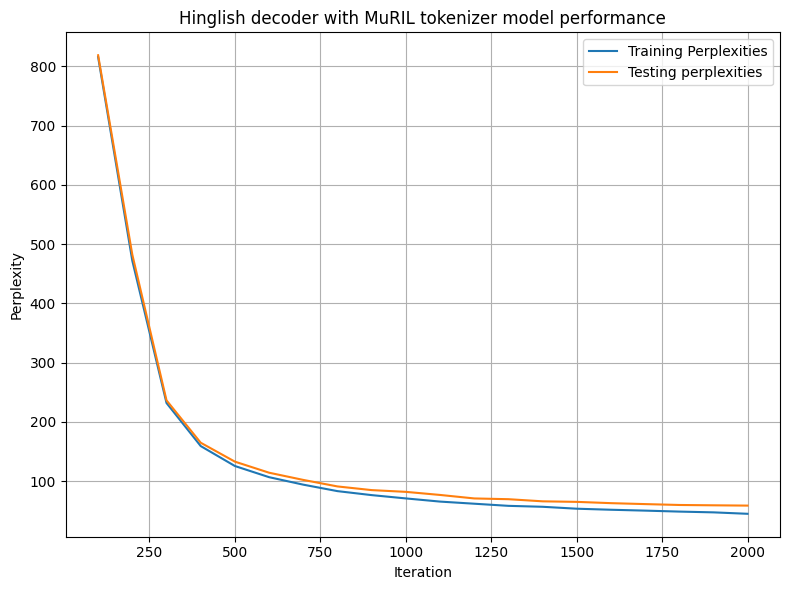

In [93]:
plt.figure(figsize=(8, 6))
plt.plot(iterations[1:], muril_train_perplexities[1:], label = "Training Perplexities")
plt.plot(iterations[1:], muril_test_perplexities[1:], label = "Testing perplexities")
plt.xlabel("Iteration")
plt.ylabel("Perplexity")
plt.title("Hinglish decoder with MuRIL tokenizer model performance")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("muril_tokenizer.png")
plt.show()

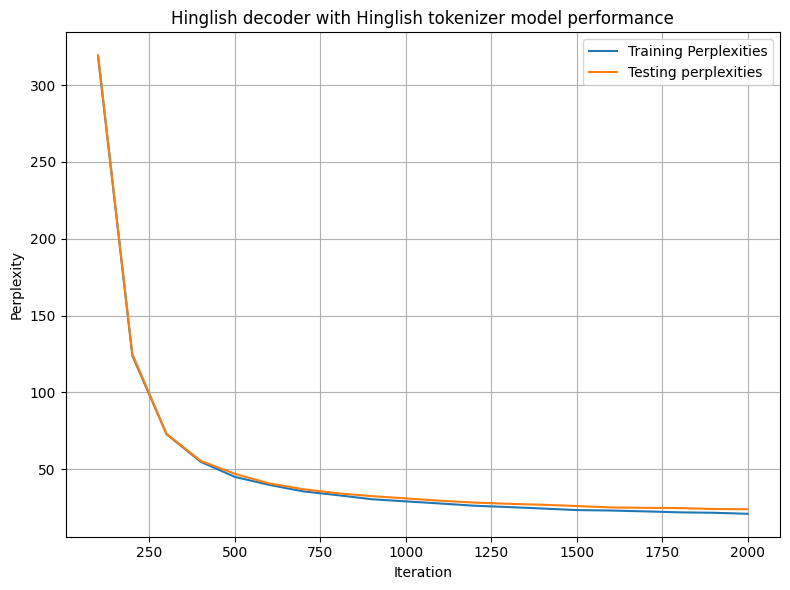

In [92]:
plt.figure(figsize=(8, 6))
plt.plot(iterations[1:], hinglish_train_perplexities[1:], label = "Training Perplexities")
plt.plot(iterations[1:], hinglish_test_perplexities[1:], label = "Testing perplexities")
plt.xlabel("Iteration")
plt.ylabel("Perplexity")
plt.title("Hinglish decoder with Hinglish tokenizer model performance")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("hinglish_tokenizer.png")
plt.show()

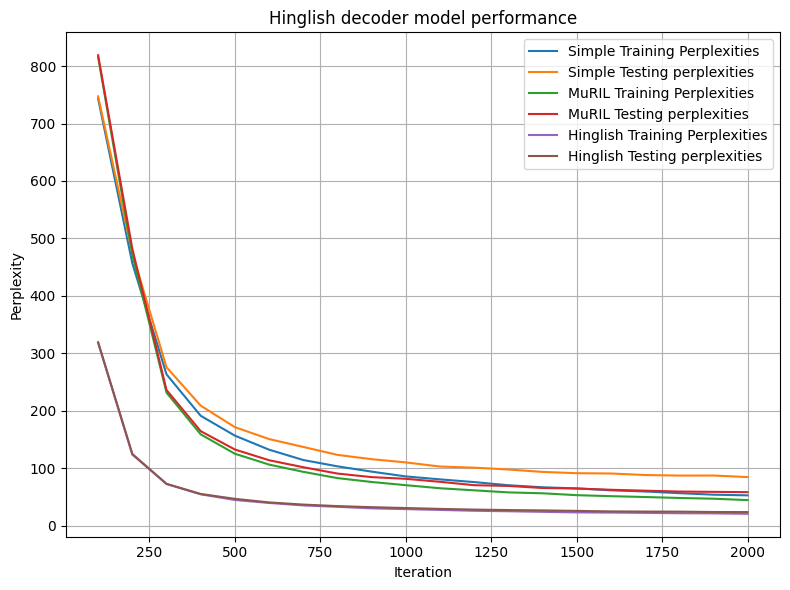

In [94]:
plt.figure(figsize=(8, 6))
plt.plot(iterations[1:], simple_train_perplexities[1:], label = "Simple Training Perplexities")
plt.plot(iterations[1:], simple_test_perplexities[1:], label = "Simple Testing perplexities")
plt.plot(iterations[1:], muril_train_perplexities[1:], label = "MuRIL Training Perplexities")
plt.plot(iterations[1:], muril_test_perplexities[1:], label = "MuRIL Testing perplexities")
plt.plot(iterations[1:], hinglish_train_perplexities[1:], label = "Hinglish Training Perplexities")
plt.plot(iterations[1:], hinglish_test_perplexities[1:], label = "Hinglish Testing perplexities")
plt.xlabel("Iteration")
plt.ylabel("Perplexity")
plt.title("Hinglish decoder model performance")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("comparison.png")
plt.show()